Download the enron dataset

In [1]:
# print("Downloading the Enron dataset (this may take a while)")
# print("To check on progress, you can cd up one level, then execute <ls -lthr>")
# print("Enron dataset should be last item on the list, along with its current size")
# print("Download will complete at about 1.82 GB")

# import requests
# url = "https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz"
# filename = "../enron_mail_20150507.tar.gz"
# with open(filename, "wb") as f:
#     r = requests.get(url)
#     f.write(r.content)
# print("Download Complete!")

# print("Unzipping Enron dataset (This may take a while)")
# import tarfile
# tfile = tarfile.open("../enron_mail_20150507.tar.gz")
# tfile.extractall(".")
# tfile.close()

# print("You're ready to go!")

To check on progress, you can cd up one level, then execute <ls -lthr>
Enron dataset should be last item on the list, along with its current size
Download will complete at about 1.82 GB
Download Complete!
Unzipping Enron dataset (This may take a while)
You're ready to go!


Convert all enron email files to csv

In [30]:
import os
import csv
from email.parser import Parser

In [31]:
# Define the root directory of the Enron dataset
MAILDIR_PATH = "./maildir" 
OUTPUT_CSV = "enron_emails.csv"

In [32]:
# Define the CSV columns
fields = ["file", "message"]

In [33]:
# Function to extract email content from a file
def extract_email(file_path):
    with open(file_path, "r", encoding="latin1") as file:
        data = file.read()
    relative_path = os.path.relpath(file_path, MAILDIR_PATH).replace(MAILDIR_PATH + '/', '')
    email_message = Parser().parsestr(data)
    return {
        "file": relative_path,
        "message": email_message.as_string()
    }

# List to store the email data
all_emails = []

# Walk through the directories and extract emails
for root, dirs, files in os.walk(MAILDIR_PATH):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            email_content = extract_email(file_path)
            all_emails.append(email_content)
        except Exception as e:
            print(f"Failed to extract {file_path}: {e}")

# Write the emails to a CSV file
with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=fields)
    csv_writer.writeheader()
    csv_writer.writerows(all_emails)

In [1]:
# import needed libraries
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import email
import re
from datetime import datetime
from dateutil import tz
import networkx as nx
import nltk
import wordcloud
import plotly.express as px
from plotly import graph_objects as go

# Machine learning and NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import scipy as sp
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
# Sentiment Analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex

# Loading data

In [3]:
# Load the dataset
df = pd.read_csv(r"../enron_emails.csv")

In [4]:
# Display the first few rows
df.head()

file                                            message
0  arnold-j/notes_inbox/36.  Message-ID: <17334447.1075857585446.JavaMail.e...
1  arnold-j/notes_inbox/19.  Message-ID: <19171686.1075857585034.JavaMail.e...
2  arnold-j/notes_inbox/50.  Message-ID: <29887033.1075857630725.JavaMail.e...
3   arnold-j/notes_inbox/3.  Message-ID: <29084893.1075849630138.JavaMail.e...
4   arnold-j/notes_inbox/9.  Message-ID: <30248874.1075857584813.JavaMail.e...

In [5]:
# Display the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


# Data cleaning and preparing

In [20]:
for message in df['message'][:1]:
    # Converts the raw email string into an email.message.Message object.
    e = email.message_from_string(message)
    print(e)

Message-ID: <17334447.1075857585446.JavaMail.evans@thyme>
Date: Thu, 16 Nov 2000 09:30:00 -0800 (PST)
From: msagel@home.com
To: jarnold@enron.com
Subject: Status
Mime-Version: 1.0
Content-Type: text/plain; charset=ANSI_X3.4-1968
Content-Transfer-Encoding: 7bit
X-From: "Mark Sagel" <msagel@home.com>
X-To: "John Arnold" <jarnold@enron.com>
X-cc: 
X-bcc: 
X-Folder: \John_Arnold_Dec2000\Notes Folders\Notes inbox
X-Origin: Arnold-J
X-FileName: Jarnold.nsf

John:
?
I'm not really sure what happened between us.? I was  under the impression 
after my visit to Houston that we were about to enter into  a trial agreement 
for my advisory work.? Somehow,?this never  occurred.? Did I say or do 
something wrong to screw this  up???
?
I don't know if you've blown this whole thing off, but I still  hope you are 
interested in trying?to create an arrangement.? As a  courtesy, here is my 
report from this past weekend.? If you are no longer  interested in my work, 
please tell me so.??Best wishes,
?
Mar

e.items(): This method returns the email's headers as key-value pairs (e.g., From, To, Subject, etc.), which you can then loop through and print.

In [22]:
# Loop through all the headers in the email message
for key, value in e.items():
    print(f'{key}: {value}')

Message-ID: <17334447.1075857585446.JavaMail.evans@thyme>
Date: Thu, 16 Nov 2000 09:30:00 -0800 (PST)
From: msagel@home.com
To: jarnold@enron.com
Subject: Status
Mime-Version: 1.0
Content-Type: text/plain; charset=ANSI_X3.4-1968
Content-Transfer-Encoding: 7bit
X-From: "Mark Sagel" <msagel@home.com>
X-To: "John Arnold" <jarnold@enron.com>
X-cc: 
X-bcc: 
X-Folder: \John_Arnold_Dec2000\Notes Folders\Notes inbox
X-Origin: Arnold-J
X-FileName: Jarnold.nsf


In [21]:
# Display the keys of the email object
print(e.keys())

['Message-ID', 'Date', 'From', 'To', 'Subject', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName']


In [24]:
print(e.values())

['<17334447.1075857585446.JavaMail.evans@thyme>', 'Thu, 16 Nov 2000 09:30:00 -0800 (PST)', 'msagel@home.com', 'jarnold@enron.com', 'Status', '1.0', 'text/plain; charset=ANSI_X3.4-1968', '7bit', '"Mark Sagel" <msagel@home.com>', '"John Arnold" <jarnold@enron.com>', '', '', '\\John_Arnold_Dec2000\\Notes Folders\\Notes inbox', 'Arnold-J', 'Jarnold.nsf']


In [30]:
# Extract specific fields from a collection of email messages
def extractmailitems(field, msg):
    elst = []  # Initialize an empty list to store the extracted fields
    
    for i, message in (msg.items()):  # Loop over the items in the 'msg' series
        e = email.message_from_string(message)  # Convert the message string into an email message object by using Python's email module
        elst.append(e.get(field))  # Extract the specified 'field' (like 'From', 'To', 'Subject') and append it to the list
       
    return elst  # Return the list of extracted fields

In [31]:
# Define the columns to extract, based on the email headers which we are interested in
columns = ['Date', 'From', 'To', 'Subject', 'X-From', 'X-To', 'X-Folder', 'X-Origin', 'X-Filename']
# Loop through the columns and extract the fields
for i in columns:
    df[i] = extractmailitems(i, df['message'])

The function `body` extracts the body (payload) from each email in the `df['message']` column and creates a new column, `Body`, to store this content in the DataFrame.

`col`: This is the column of email messages from a DataFrame, which contains the raw email strings (i.e., the message column of your DataFrame).


In [33]:
# Extrwct the email body
def body(col):
    bodycolumn = []  # Initialize an empty list to store the body content of emails
    
    for message in col.values:  # Loop through each message in the 'col' column of the DataFrame
        e = email.message_from_string(message)  # Convert the raw email string into an email.message.Message object
        bodycolumn.append(e.get_payload())  # Extract the email body (payload) and append it to the list
    
    return bodycolumn  # Return the list of email bodies

df['Body'] = body(df['message'])

The provided function `employees` is designed to extract employee names from a column named `file` in a DataFrame. The function assumes that the `file` column contains strings where the employee's name is the first part before a `/`.

In [34]:
# extract employee names from the 'file' column
def employees(files):
    employees = []  # Initialize an empty list to store employee names
    for i, employee in files.items():  # Iterate over the 'file' column (as a series)
        employee = employee.split('/')[0]  # Split the string on '/' and take the first part (employee name)
        employees.append(employee)  # Add the extracted name to the list
    return employees  # Return the list of employee names

df['Employee'] = employees(df['file'])

In [32]:
df.sample(5)

file  \
76322            delainey-d/_sent_mail/169.   
447193            fischer-m/notes_inbox/72.   
136711                  sager-e/inbox/1052.   
175505                storey-g/personal/51.   
510860  hernandez-j/discussion_threads/350.   

                                                  message  \
76322   Message-ID: <11619396.1075854482980.JavaMail.e...   
447193  Message-ID: <32296225.1075840461239.JavaMail.e...   
136711  Message-ID: <23080519.1075861323888.JavaMail.e...   
175505  Message-ID: <3687380.1075841599549.JavaMail.ev...   
510860  Message-ID: <21279803.1075855530921.JavaMail.e...   

                                         Date                          From  \
76322   Sat, 28 Oct 2000 05:30:00 -0700 (PDT)      david.delainey@enron.com   
447193  Wed, 26 Jun 2002 01:31:00 -0700 (PDT)           jeff.duff@enron.com   
136711  Tue, 27 Nov 2001 17:29:56 -0800 (PST)    arsystem@mailman.enron.com   
175505   Sat, 7 Apr 2001 18:46:00 -0700 (PDT)  judy.l.wood@ca.pwcglobal.com   
510860  Mon, 13 Nov 2000 02:07:00 -0800 (PST)     jennifer.cutaia@enron.com   

                                                       To  \
76322                          colleen.sullivan@enron.com   
447193                            julie.johnson@enron.com   
136711                          elizabeth.sager@enron.com   
175505                                  gstorey@enron.com   
510860  judy.hernandez@enron.com, eve.puckett@enron.co...   

                                                  Subject  \
76322                               Transportation Status   
447193                                       Work request   
136711  Your Approval is Overdue: Access Request for\n...   
175505                Estimate of tax owing on April 16th   
510860                                       Staying Busy   

                                             X-From  \
76322                              David W Delainey   
447193                                    Jeff Duff   
136711  ARSystem <ARSystem@mailman.enron.com>@ENRON   
175505                 judy.l.wood@ca.pwcglobal.com   
510860                              Jennifer Cutaia   

                                                     X-To  \
76322                                    Colleen Sullivan   
447193                                      Julie Johnson   
136711  Sager, Elizabeth </O=ENRON/OU=NA/CN=RECIPIENTS...   
175505                        gstorey <gstorey@enron.com>   
510860  Judy Hernandez, Eve Puckett, Crystal Reyna, Sa...   

                                                 X-Folder     X-Origin  \
76322    \David_Delainey_Dec2000\Notes Folders\'sent mail   Delainey-D   
447193    \mark fischer 7-12-02\Notes Folders\Notes inbox    FISCHER-M   
136711    \ESAGER (Non-Privileged)\Sager, Elizabeth\Inbox      Sager-E   
175505                  \ExMerge - Storey, Geoff\personal     STOREY-G   
510860  \Juan_Hernandez_Dec2000\Notes Folders\Discussi...  Hernandez-J   

                             X-Filename  \
76322                       ddelain.nsf   
447193  mark fischer 7-12-02 LNotes.nsf   
136711      ESAGER (Non-Privileged).pst   
175505         geoff storey 6-26-02.PST   
510860                      jhernan.nsf   

                                                     Body     Employee  
76322   Colleen, thanks for the update - as another pa...   delainey-d  
447193  Julie,\n\nCould you print off the current work...    fischer-m  
136711  This request has been pending your approval fo...      sager-e  
175505  Hi Geoff,\n\nWe have prepared an estimate of y...     storey-g  
510860  ---------------------- Forwarded by Jennifer C...  hernandez-j

In [35]:
# Drop unimportant data columns and empty cells
df.drop(columns = ['file', 'message'], inplace=True)
# Removes all rows from the DataFrame df where any value in the row is missing
df.dropna(axis = 0, inplace=True)
df.sample(5)

Date                     From  \
164182  Wed, 29 Nov 2000 03:06:00 -0800 (PST)  marcie.milner@enron.com   
419737   Sat, 2 Feb 2002 00:36:53 -0800 (PST)     pete.davis@enron.com   
190896  Thu, 10 May 2001 01:30:00 -0700 (PDT)    soblander@carrfut.com   
296237  Fri, 26 Jan 2001 01:55:00 -0800 (PST)  phillip.allen@enron.com   
85096   Tue, 25 Jan 2000 01:53:00 -0800 (PST)  chris.germany@enron.com   

                                                  To  \
164182  roger.yang@enron.com, robert.frank@enron.com   
419737                          pete.davis@enron.com   
190896                         soblander@carrfut.com   
296237                           mary.gray@enron.com   
85096                  hboyd@columbiaenergygroup.com   

                                        Subject  \
164182                       PG&E Advice 2056-E   
419737  Start Date: 2/1/02; HourAhead hour: 23;   
190896     Carr Futures Research : Data Updates   
296237                        NGI access to eol   
85096                          Re: NYSEG - 1/26   

                                                   X-From  \
164182                                      Marcie Milner   
419737  Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=P...   
190896                              SOblander@carrfut.com   
296237                                    Phillip K Allen   
85096                                       Chris Germany   

                                                     X-To  \
164182                           Roger Yang, Robert Frank   
419737  Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=P...   
190896                              soblander@carrfut.com   
296237                                    Mary Griff Gray   
85096               hboyd@columbiaenergygroup.com @ ENRON   

                                                 X-Folder     X-Origin  \
164182  \Jeff_Dasovich_Dec2000\Notes Folders\All docum...   DASOVICH-J   
419737     \ExMerge - Williams III, Bill\Schedule Crawler  WILLIAMS-W3   
190896        \John_Griffith_Nov2001\Notes Folders\Market   GRIFFITH-J   
296237         \Phillip_Allen_June2001\Notes Folders\Sent      Allen-P   
85096     \Chris_Germany_Dec2000\Notes Folders\'sent mail    Germany-C   

          X-Filename                                               Body  \
164182  jdasovic.nsf  The purpose of this filing is to provide PG&E=...   
419737                \n\nStart Date: 2/1/02; HourAhead hour: 23;  N...   
190896  jgriffit.nsf  (See attached file: Import & Export Prices.pdf...   
296237    pallen.nsf  Griff,\n  \nCan you accomodate Dexter as we ha...   
85096    cgerman.nsf  I'm forgot, what do you need at Tenn O&R for t...   

           Employee  
164182   dasovich-j  
419737  williams-w3  
190896   griffith-j  
296237      allen-p  
85096     germany-c

In [36]:
# Count top 20 of the most active employees
df.Employee.value_counts()[:20]

Employee
kaminski-v      27801
dasovich-j      27463
kean-s          23896
mann-k          23302
jones-t         19739
shackleton-s    18371
taylor-m        13371
farmer-d        12862
germany-c       12267
beck-s          11555
nemec-g         10467
symes-k         10332
scott-s          7788
rogers-b         7760
bass-e           7638
sanders-r        7096
campbell-l       6085
guzman-m         6030
shapiro-r        5872
lenhart-m        5832
Name: count, dtype: int64

In [37]:
# changing the date format and type from string to date object
df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)

/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_20967/2007279768.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)


In [38]:
# creating a year column from the date column
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [39]:
df.Year.value_counts()

Year
2001    256402
2000    192904
2002     34782
1999     10896
1980       316
1998       166
2004        70
2044         3
1986         2
2020         2
2007         1
2005         1
2043         1
1997         1
Name: count, dtype: int64

In [49]:
# a function for cleaning text in columns

def extract(col):
    regcol = []
    for sent in col.values:
        
        if str(sent).startswith('<'):  
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))           
            
        elif re.match(r'^\d+', str(sent)):
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[0-9]+\'?-?', str(reg))
           
        else:
            reg = re.split(r'@|<|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))
            
        reg = re.sub(r'[\'\",]', '', str(reg))
        regcol.append(str(reg.strip('[]')))
           
            
    return regcol

In [50]:
df['X-From'] = extract(df['X-From'])
df['X-To'] = extract(df['X-To'])

In [51]:
df['X-From'].value_counts()[:20]

X-From
Kay Mann               16314
Vince J Kaminski       14329
Jeff Dasovich           9715
Enron Announcements     8577
Tana Jones              8065
Sara Shackleton         7950
Chris Germany           7298
Steven J Kean           6211
Schedule Crawler        6179
Kate Symes              5223
Eric Bass               4861
Matthew Lenhart         4712
Sally Beck              3868
Debra Perlingiere       3647
Drew Fossum             3622
Carol St Clair          3544
Benjamin Rogers         3311
Gerald Nemec            3244
Richard B Sanders       3209
Phillip M Love          3107
Name: count, dtype: int64

In [52]:
df['X-To'].value_counts()[:20]

X-To
pete davis             5337
vkaminski              4749
Tana Jones             4587
Davis Pete             3821
Jeff Dasovich          3669
Sara Shackleton        3378
All Enron Worldwide    3324
Vince J Kaminski       3321
Kate Symes             3211
Steven J Kean          3086
Mark Taylor            2732
Kay Mann               2380
Daren J Farmer         2292
Kitchen Louise         2208
Gerald Nemec           1986
All Enron Houston      1956
Sally Beck             1912
Suzanne Adams          1786
klay                   1533
Benjamin Rogers        1369
Name: count, dtype: int64

In [53]:
df.sample(5)

Date                       From  \
408302 2001-01-31 05:15:00+00:00   tracy.geaccone@enron.com   
294583 2001-04-18 14:14:00+00:00  tori.kuykendall@enron.com   
445536 2001-10-15 21:06:06+00:00    nytasha.sims@dynegy.com   
416068 2001-03-29 08:16:00+00:00         dan.hyvl@enron.com   
305457 2000-12-08 10:03:00+00:00    samuel.schott@enron.com   

                                                       To  \
408302                              lerea.pharr@enron.com   
294583                           daniel.diamond@enron.com   
445536                                  l..mims@enron.com   
416068                        debra.perlingiere@enron.com   
305457  camille.gerard@enron.com, mary.gosnell@enron.c...   

                                                  Subject           X-From  \
408302  Re: Class Request: PPT97-931 PowerPoint 97, In...   Tracy Geaccone   
294583                                                RE:  Tori Kuykendall   
445536                                       RE: Slow Day     Nytasha Sims   
416068                                    City of Anaheim       Dan J Hyvl   
305457   Re: ClickPaper approvals, 12-7-00 _ GCP Response    Samuel Schott   

                                                     X-To  \
408302                                        LeRea Pharr   
294583                                     Daniel Diamond   
445536                                     Mims Patrice L   
416068                                  Debra Perlingiere   
305457  Camille Gerard Mary G Gosnell Adnan Patel Tany...   

                                                 X-Folder         X-Origin  \
408302  \TGEACCO (Non-Privileged)\Geaccone, Tracy\'Sen...       Geaccone-T   
294583  \Tori_Kuykendall_Jun2001\Notes Folders\'sent mail     Kuykendall-T   
445536                      \PMIMS (Non-Privileged)\Inbox  Mims-Thurston-P   
416068      \Dan_Hyvl_Dec2000_June2001\Notes Folders\Sent           HYVL-D   
305457     \Tanya_Jones_Dec2000\Notes Folders\Notes inbox          JONES-T   

                          X-Filename  \
408302  TGEACCO (Non-Privileged).pst   
294583                   tkuyken.nsf   
445536    PMIMS (Non-Privileged).pst   
416068                     dhyvl.nsf   
305457                    tjones.nsf   

                                                     Body         Employee  \
408302  approved\n\n\n\n\nLeRea Pharr@ECT\n01/30/2001 ...       geaccone-t   
294583  can you just let me know one way or the other ...     kuykendall-t   
445536  \nI can not believe she called you regarding s...  mims-thurston-p   
416068  Debra,\n Here is the new contract.  Please for...           hyvl-d   
305457  GCP adjustments are highlighted in red.\n\n \n...          jones-t   

        Year  
408302  2001  
294583  2001  
445536  2001  
416068  2001  
305457  2000

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495547 entries, 0 to 517400
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   Date        495547 non-null  datetime64[ns, UTC]
 1   From        495547 non-null  object             
 2   To          495547 non-null  object             
 3   Subject     495547 non-null  object             
 4   X-From      495547 non-null  object             
 5   X-To        495547 non-null  object             
 6   X-Folder    495547 non-null  object             
 7   X-Origin    495547 non-null  object             
 8   X-Filename  495547 non-null  object             
 9   Body        495547 non-null  object             
 10  Employee    495547 non-null  object             
 11  Year        495547 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(1), object(10)
memory usage: 47.3+ MB


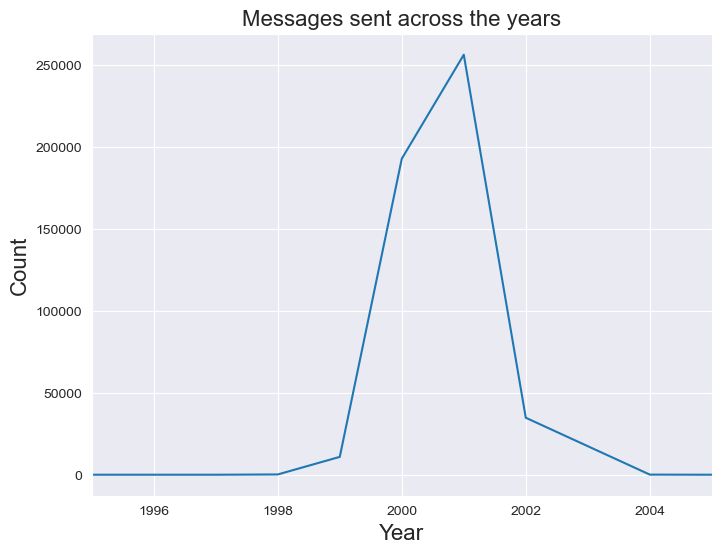

In [55]:
# make a diagram to show the count of messages sent per year
ax = df.groupby(df.Year)['X-Origin'].count().plot(figsize = (8,6))
ax.set_xlim(1995,2005)
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
ax.set_title('Messages sent across the years', fontsize = 16)
plt.show()

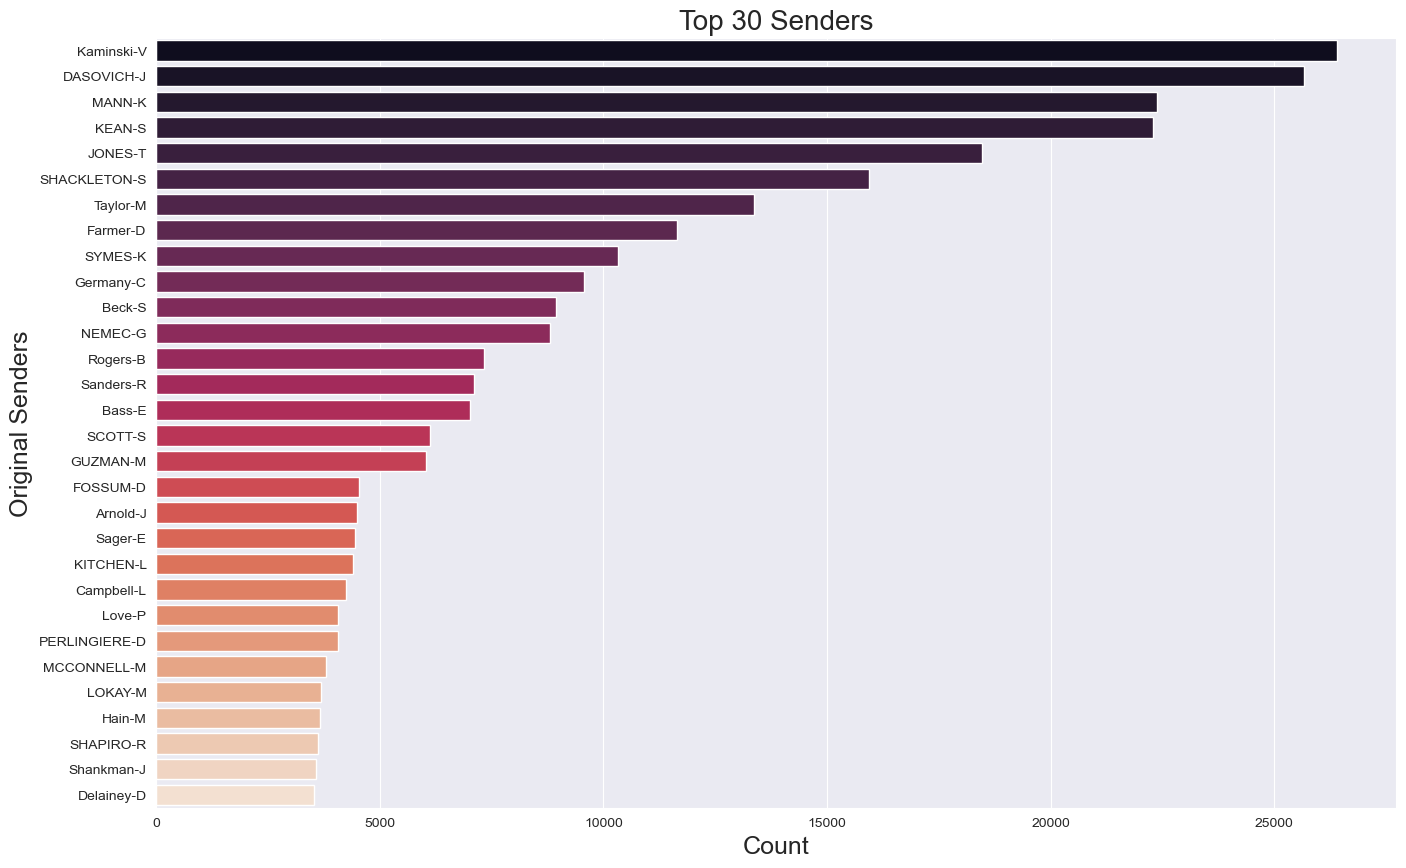

In [56]:
# diagram for showing top senders
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['X-Origin'].value_counts().values[:30], y = df['X-Origin'].value_counts().keys()[:30] ,palette = 'rocket', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Original Senders', fontsize = 18)
ax.set_title('Top 30 Senders', fontsize = 20)
plt.show()

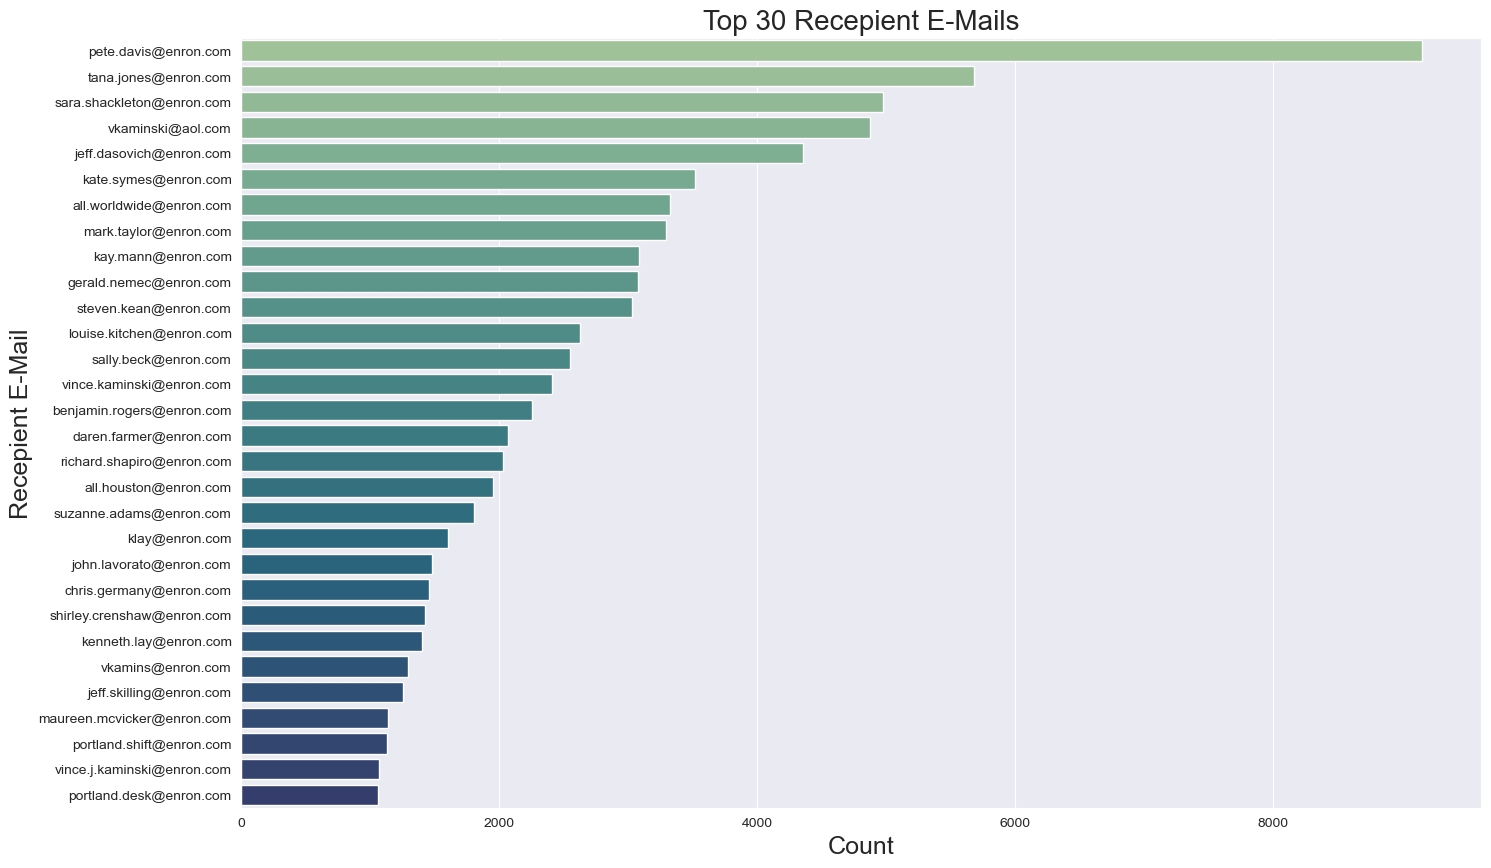

In [57]:
# diagram showing top recepients
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['To'].value_counts().values[:30], y = df['To'].value_counts().keys()[:30] ,palette = 'crest', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Recepient E-Mail', fontsize = 18)
ax.set_title('Top 30 Recepient E-Mails', fontsize = 20)
plt.show()

In [58]:
userlist = df['X-Origin'].unique()

In [59]:
useryears = []
for user in userlist:
    year = df.loc[df['X-Origin'] == user, 'Year'].iloc[0]
    useryears.append(year)
    useryears

In [60]:
usercount = []
counter = 0
for name in userlist:
    for user in df['X-Origin'].values:
        if user == name:
            counter += 1
    usercount.append(counter)
    counter = 0

In [61]:
dataf = sorted(list(zip(userlist, usercount, useryears)), key= lambda user: user[1], reverse = True)[:30]

In [62]:
dataf = pd.DataFrame(dataf)
dataf.columns = ['User', 'Count', 'Year']
dataf.head()

User  Count  Year
0  Kaminski-V  26409  2001
1  DASOVICH-J  25656  2001
2      MANN-K  22372  2001
3      KEAN-S  22296  2000
4     JONES-T  18475  2000

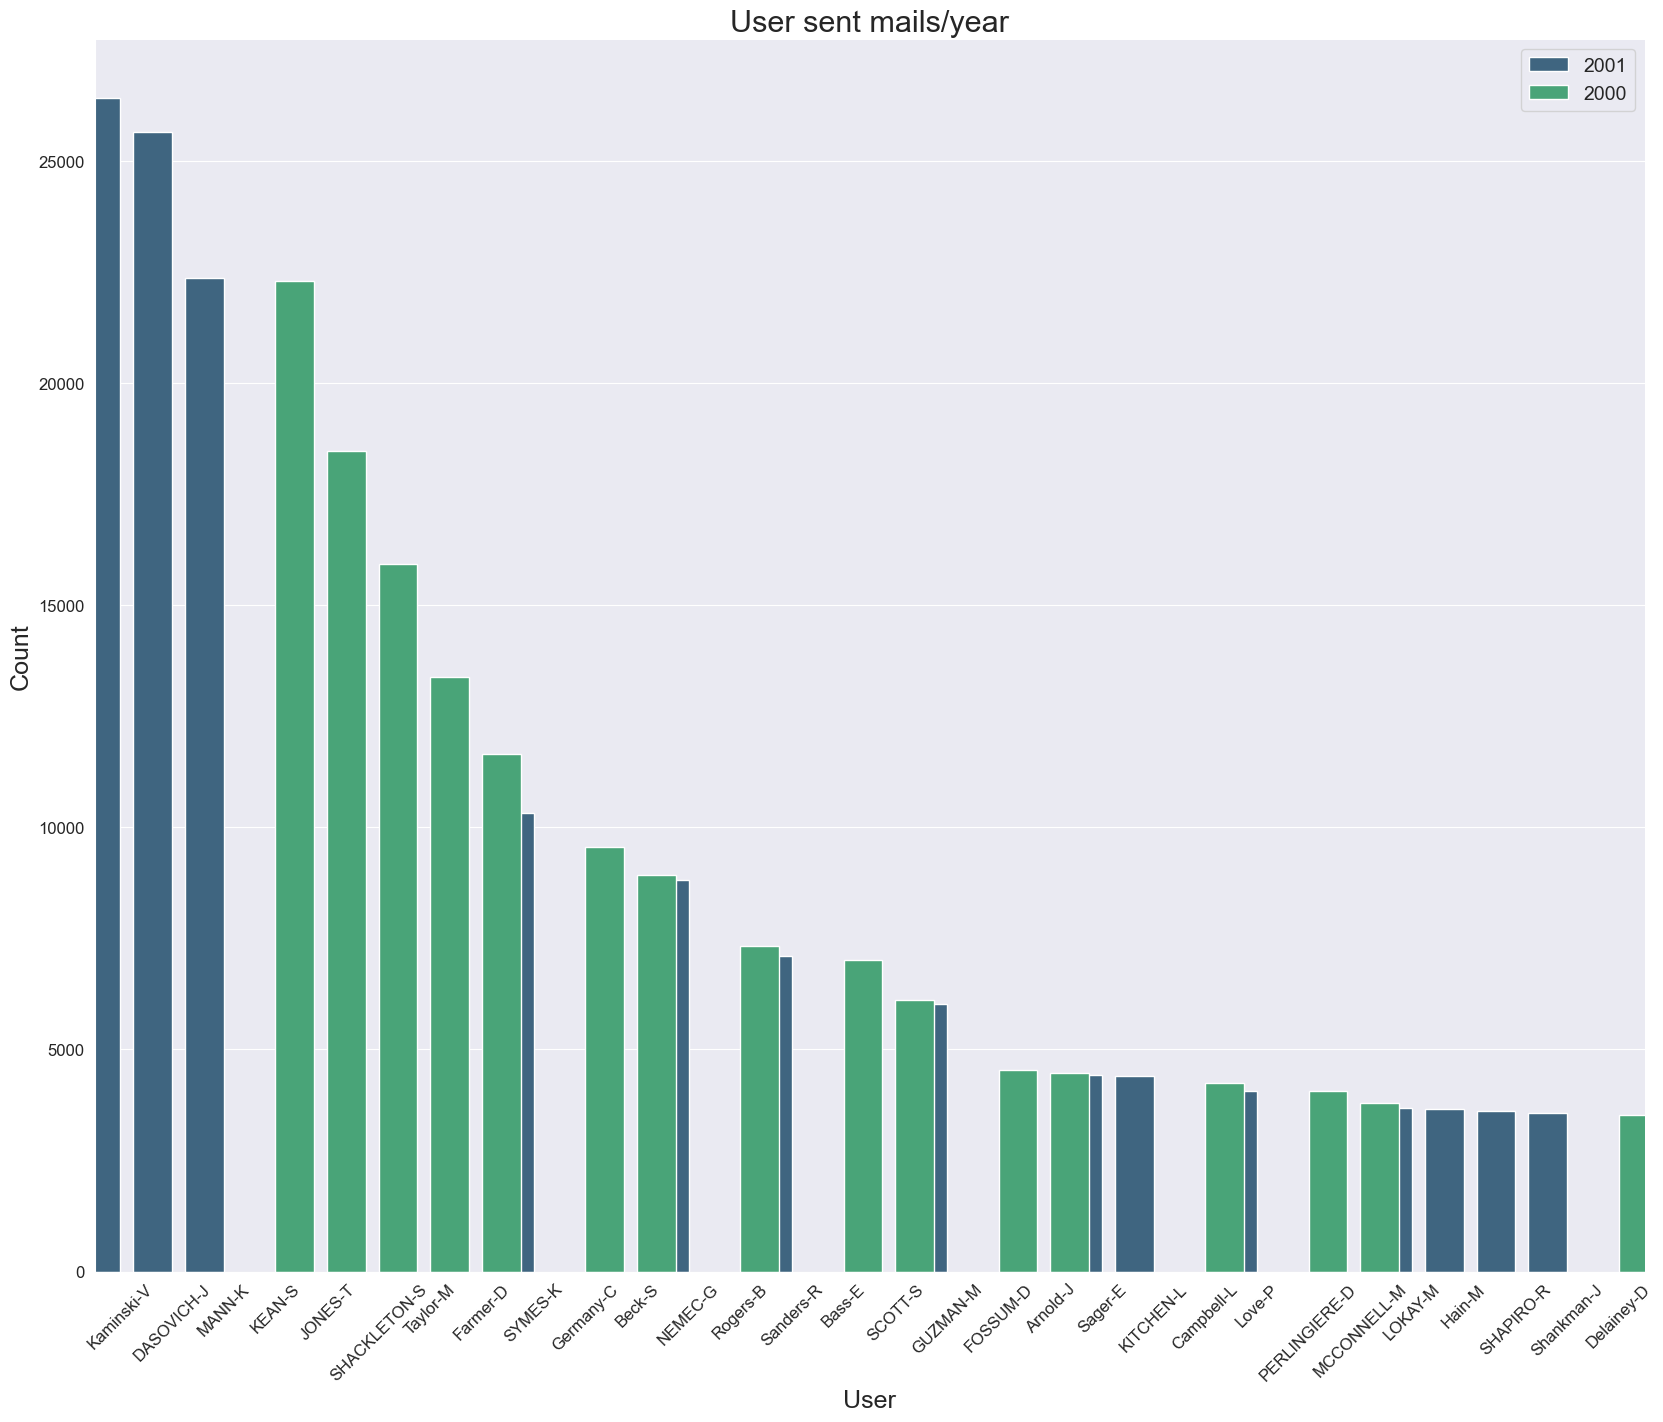

In [64]:
# diagram showing top users and count of mails sent per year
dataf['Year'] = dataf['Year'].astype(str)  # Ensure 'Year' is of type string
plt.figure(figsize = (20,16))
ax = sns.barplot(data = dataf, x ='User', y = 'Count', hue = 'Year', palette = 'viridis' , saturation = 0.7, width = 1.5)
sns.despine()
plt.xlabel('User', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title('User sent mails/year', fontsize = 22)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.show()

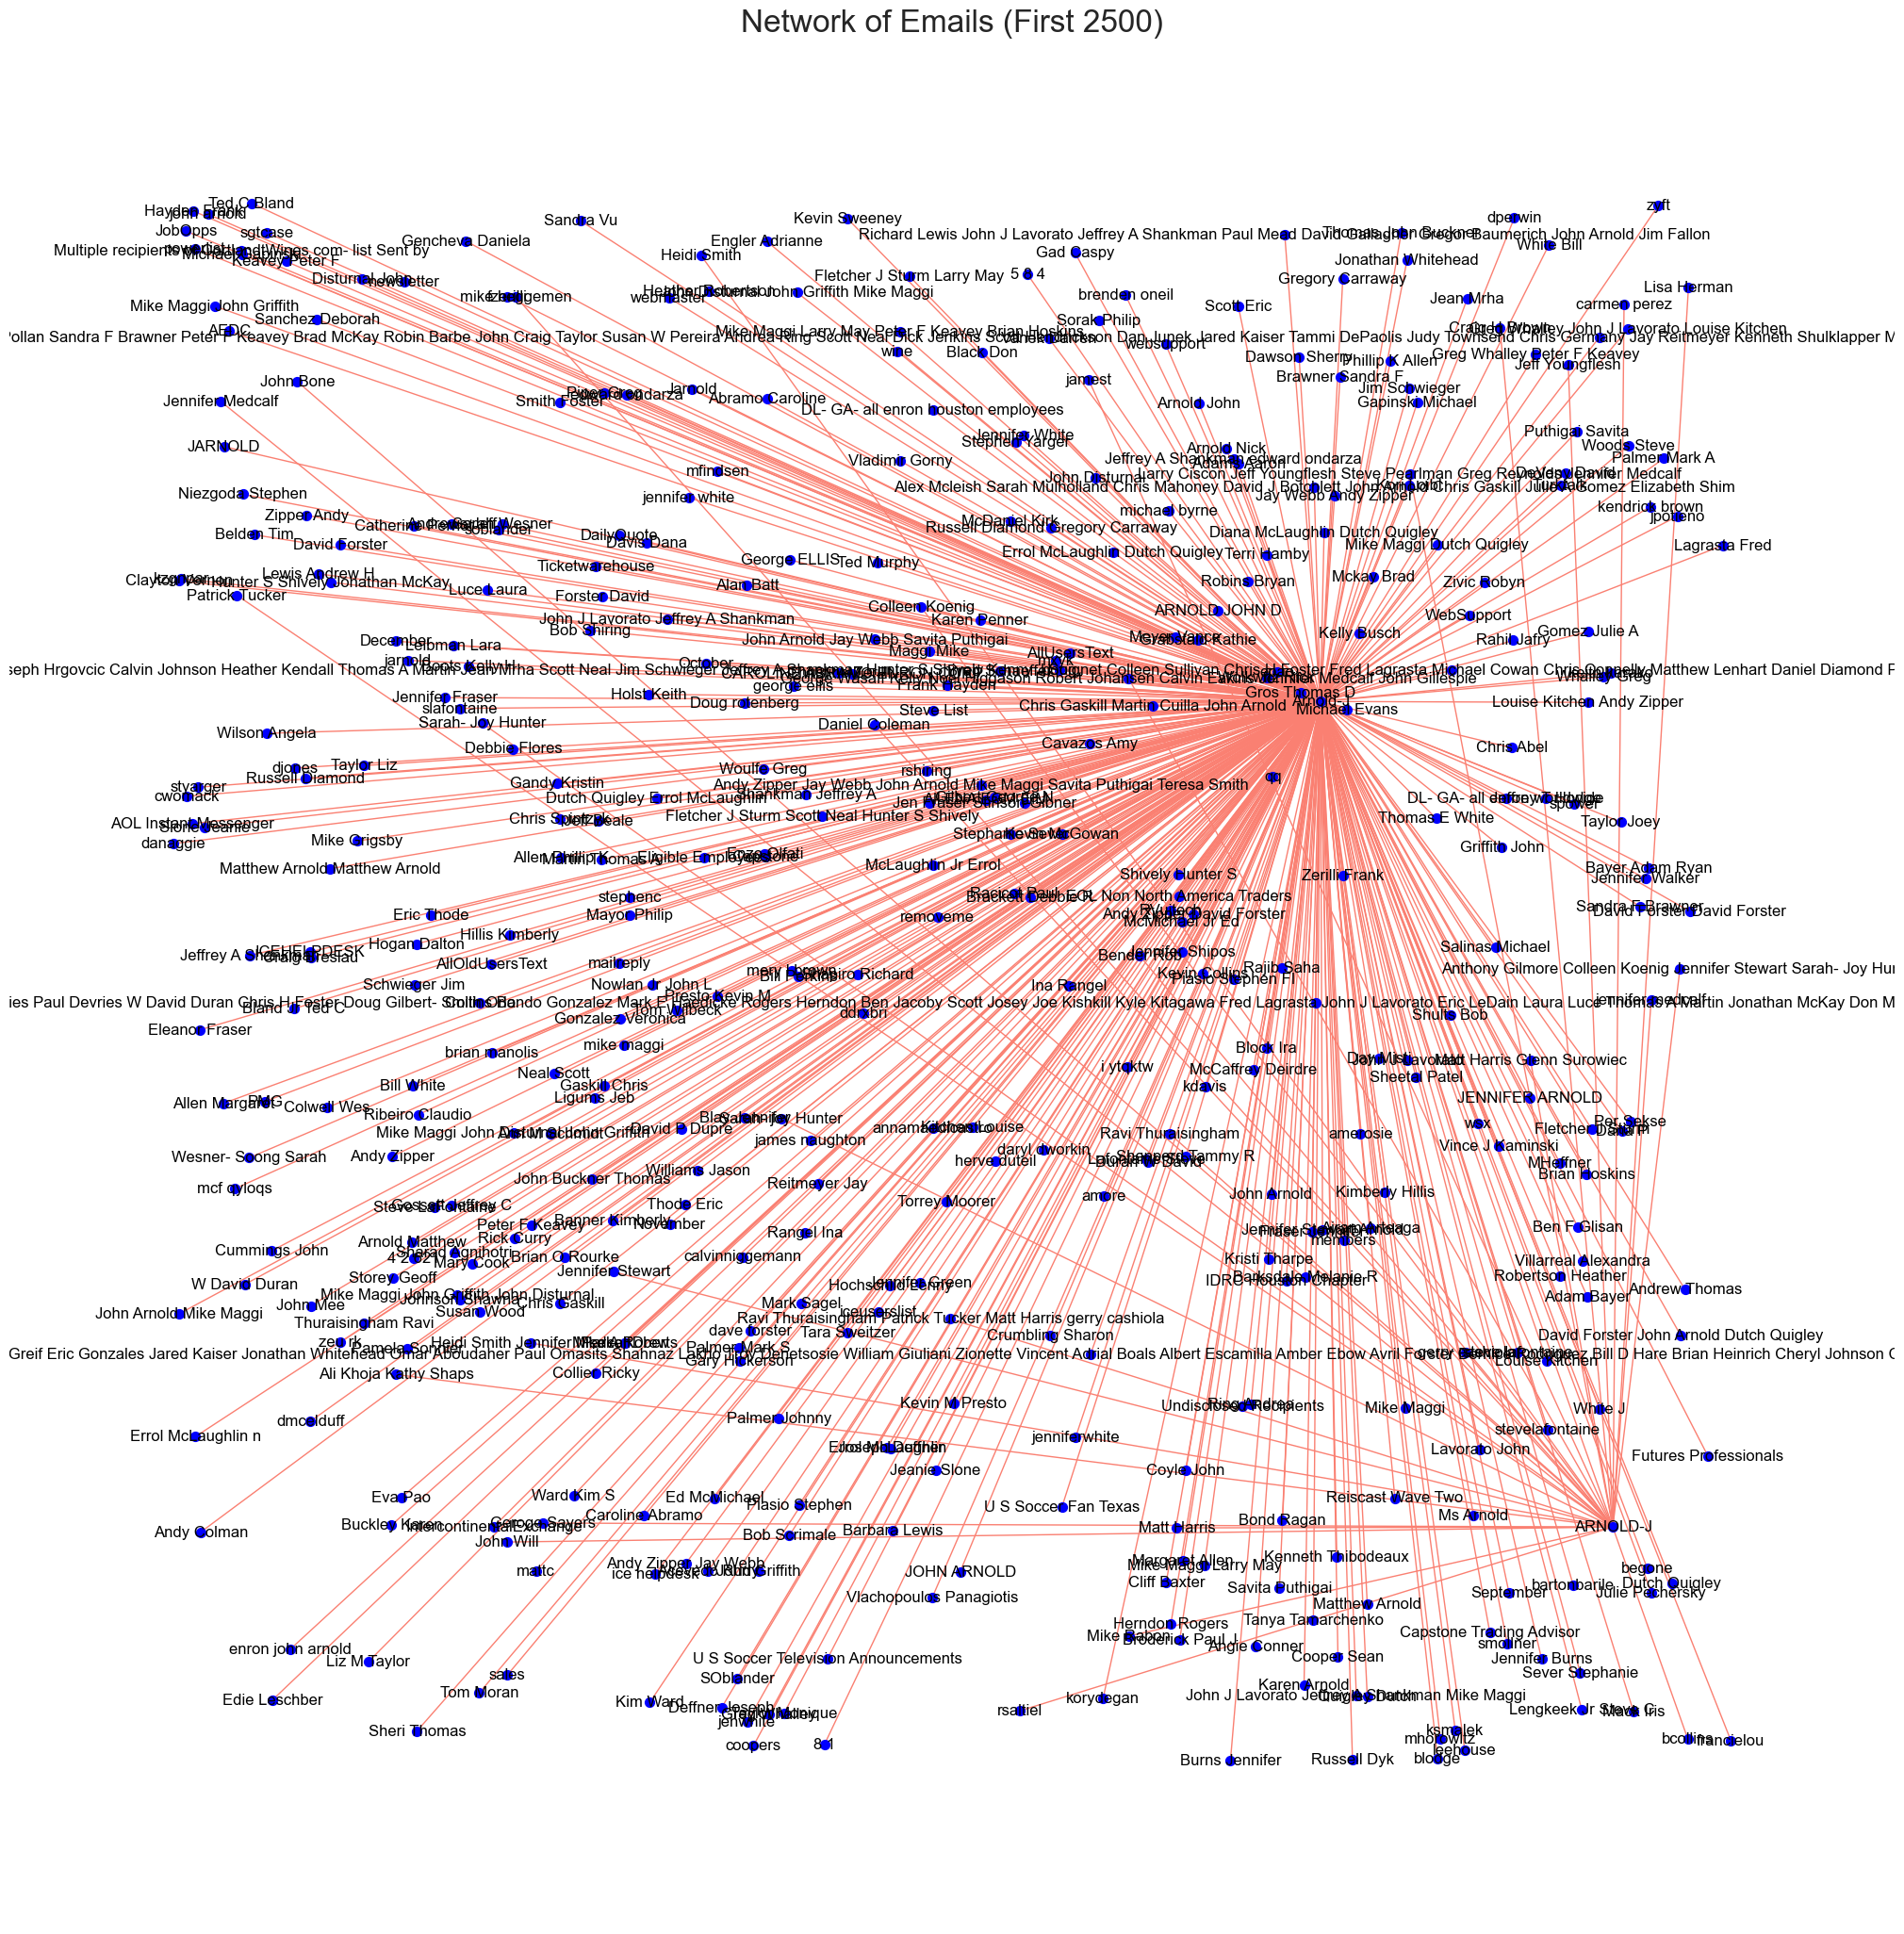

In [65]:
# a network of first 2500 rows showing the network of Allen P
plt.figure(figsize = (20, 20))
G = nx.from_pandas_edgelist(df[:2500], 'X-Origin', 'X-To')
pos = nx.draw_random(G, node_size = 50, node_color = 'blue', edge_color = 'salmon', with_labels = True)
plt.title('Network of Emails (First 2500)', fontsize = 24)
plt.show()

# Machine Learning and NLP on the dataset

In [66]:
stopwords = nltk.corpus.stopwords.words('english')
newstopwords = ['Re', 'FW', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead']
for i in newstopwords:
    stopwords.append(i)

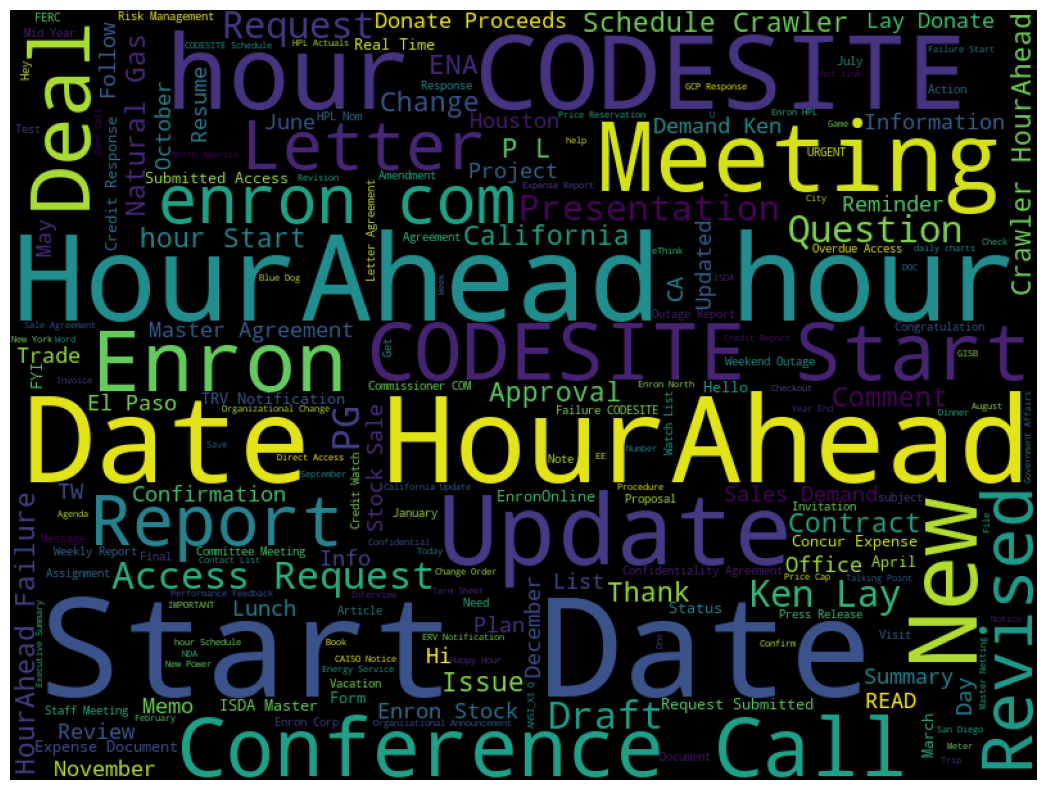

In [67]:
subjects = ' '.join(df['Subject'].values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 200, stopwords = stopwords).generate(subjects)
ax.imshow(wc)
plt.axis('off')
plt.show()

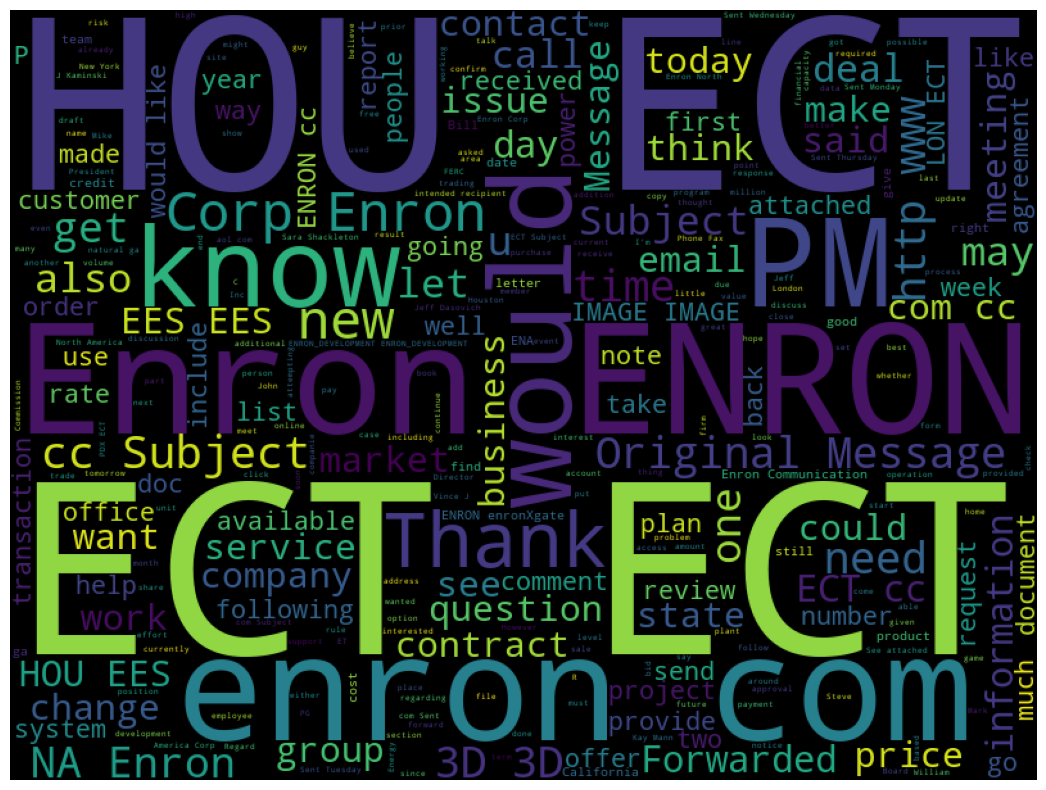

In [68]:
content = ' '.join(df['Body'].sample(5000).values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 300, stopwords = stopwords).generate(content)
ax.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
nltk.download('wordnet')

In [ ]:
nltk.download('punkt')

In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [69]:
# function for cleaning the body text
def cleaningbody(col):
    msgcol = []
    for msg in col.values:
        msg = re.sub(r'[<>\n+\t+\s+\*]', ' ', msg)
        msg = re.sub(r'[0-9]+[a-zA-Z]+\d+[?!].DOC', ' ', msg)
        msg = re.sub(r'[?\s+\-+\s+?_=~]', ' ', msg)
        msg = re.sub(r' +', ' ', msg)
        msg = msg.lower().strip(' ')
        msgcol.append(msg)
    return msgcol
df['Body'] = cleaningbody(df['Body'])

In [70]:
# preparing the lemmatization function
lemmatizer = WordNetLemmatizer()

In [ ]:
# Tokenizing and lemmatizing the text to prepare for classification and sentiment analysis
text = []
for msg in df['Body'].values:
    msg_tokens = word_tokenize(msg)
    msg_tokens = [token.lower() for token in msg_tokens if token.isalpha()]
    msg_tokens = [word for word in msg_tokens if not word in stopwords]
    msg_tokens = [lemmatizer.lemmatize(word) for word in msg_tokens]
    
    text.append(msg_tokens)

In [ ]:
text = [' '.join(message) for message in text]

In [ ]:
# vectorizing the data using Tfidfvectorizer
vectorizer = TfidfVectorizer(min_df = 5, max_features = 5000, stop_words = stopwords, norm = 'l1')
data = vectorizer.fit_transform(text)

In [ ]:
# Normalizing the data
data_norm = normalize(data)

In [ ]:
print(data_norm.shape)

In [ ]:
# Decomposition of the data and decreasing alot of features
svd = TruncatedSVD(n_components = 2, n_iter = 10, random_state = 42)
datasvd = svd.fit_transform(data_norm)

In [ ]:
datasvd.shape

In [ ]:
# Use the Elbow method to define the optimal number of clusters for kmeans clustering
max_iter = 1000
sumsquares = []
number_clusters = range(1,11)
for i in number_clusters:
    kmeans = KMeans(n_clusters = i, max_iter = max_iter, n_init = 'auto')
    kmeans.fit(datasvd)
    sumsquares.append(kmeans.inertia_)
plt.figure(figsize = (8,6))
plt.plot(number_clusters, sumsquares)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Sum of Squared Distances', fontsize = 14)
plt.title('Elbow Method', fontsize = 16)
plt.show()

In [ ]:
n_clusters = 6
clf = KMeans(n_clusters = n_clusters,init = 'random', max_iter = max_iter, tol = 0.0001, algorithm = 'lloyd', n_init = 'auto', random_state = 42)
fittedkmeans = clf.fit_predict(datasvd)
centroids = clf.cluster_centers_

In [ ]:
# A diagram showing the clusters
plt.figure(figsize = (8,6))
plt.scatter(datasvd[:,0], datasvd[:,1], c = fittedkmeans, s = 50, cmap = 'viridis', alpha = 0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], s = 150, c = 'black', alpha = 0.8)
plt.annotate('Cluster 0', xy = (centroids[0][0], centroids[0][1]), xytext = (centroids[0][0] + 0.02, centroids[0][1] + 0.03), color = 'white', fontsize = 12)
plt.annotate('Cluster 1', xy = (centroids[1][0], centroids[1][1]), xytext = (centroids[1][0] + 0.02, centroids[1][1] + 0.02), color = 'white', fontsize = 12)
plt.annotate('Cluster 2', xy = (centroids[2][0], centroids[2][1]), xytext = (centroids[2][0] - 0.05, centroids[2][1] - 0.06), color = 'white', fontsize = 12)
plt.annotate('Cluster 3', xy = (centroids[3][0], centroids[3][1]), xytext = (centroids[3][0] - 0.01, centroids[3][1] - 0.07), color = 'white', fontsize = 12)
plt.annotate('Cluster 4', xy = (centroids[4][0], centroids[4][1]), xytext = (centroids[4][0] - 0.03, centroids[4][1] + 0.04), color = 'white', fontsize = 12)
plt.annotate('Cluster 5', xy = (centroids[5][0], centroids[5][1]), xytext = (centroids[5][0] - 0.03, centroids[5][1] + 0.03), color = 'white', fontsize = 12)

plt.show()

In [ ]:
# extract top words in every cluster using the inverse_transform method
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1] #(10,5000)
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
        
    print()

# Sentiment Analysis

In [ ]:
# praeparing the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
df['sentiment scores'] = [analyzer.polarity_scores(message) for message in text]
df.sample(5)

In [ ]:
# Determine the positive and negative scores
sentiment = []
for i in df['sentiment scores'].values:
    if i['compound'] > 0.05:
        sentiment.append('Positive')
    elif i['compound'] < 0.05:
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['Sentiment'] = sentiment

In [ ]:
sentiment_values = df['Sentiment'].value_counts()
sentiment_values

In [ ]:
# a graph for the sentiment as a funnel shaped graph
fig = px.funnel(sentiment_values)
fig.show()

In [ ]:
# defining another function for sentiment analysis with different emotions using NRCLex lexicon
def sentiment(message):
    text = NRCLex(message)
    if text.top_emotions[0][1] == 0.0:
        return 'No Emotion'
    else:
        return text.top_emotions[0][0]
df['Emotions'] =  df['Body'].apply(sentiment)
df.sample(5)

In [ ]:
emotions = df['Emotions'].value_counts()
emotion_chart = pd.DataFrame(emotions)
emotion_chart = emotion_chart.drop('No Emotion', axis = 0)
emotion_chart

In [ ]:
# A pie chart for showing the percentage of every emotion in the text
labels = emotion_chart.index.tolist()
plt.figure(figsize = (11,11))
plt.pie(emotion_chart['Emotions'].values, labels = labels , autopct = '%1.1f%%', labeldistance= 1.1)
plt.title('Emotions', fontsize = 14)
plt.legend(loc = 'upper right')
plt.show()